In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [13]:
def calc_mass_conc(df, df_keys, bin_cut_points, bin_mid_points, rho):
    bin_widths = []
    for i, bin in enumerate(bin_cut_points[:-1]):
        width = bin_cut_points[i+1] - bin
        bin_widths.append(width)
    
    new_df = pd.DataFrame({'Time': df['Time']})
    for i, key in enumerate(df_keys):
        n_M = (rho / 10**6) * (np.pi / 6) * bin_mid_points[i]**3 * df[key] # in ug * um**-1 * cm**-3
        mass_conc = n_M * bin_widths[i] * 10**6
        new_df[key] = mass_conc

    return new_df

In [66]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()
OPS_ax_labels = ['Particle diameter / $\mu$m', 'dN / #/cm$^{3}$', 'dM / $\mu$g/m$^{3}$']

In [16]:
OPS_mass_conc = {}
for key in OPS_dict_keys:
    mass_conc = calc_mass_conc(OPS_APS[key], OPS_bins, OPS_cut_point, OPS_mid_point, 7.86)
    OPS_mass_conc[key] = mass_conc

In [67]:
def bin_mean(timestamps, df, df_keys, timelabel):
    mean = []
    std = []

    start_time = pd.to_datetime(timestamps[0])
    end_time = pd.to_datetime(timestamps[1])

    time = pd.to_datetime(df[timelabel])
    time_filter = (time >= start_time) & (time <= end_time)

    for key in df_keys:
        conc = np.array(df[key].dropna())
        
        # Convert the concentration data to numeric, coercing errors
        conc = pd.to_numeric(conc, errors='coerce')
        filtered_conc = conc[time_filter]
        bin_mean = filtered_conc.mean()
        bin_std = filtered_conc.std()

        mean.append(bin_mean)
        std.append(bin_std)
    
    return mean, std

def plot_bin_mean(ax, timestamps, df_number, df_mass, df_keys, timelabel, bins, clr, inst_error, axis_labels, mass):
    mean_number, std_number = bin_mean(timestamps, df_number, df_keys, timelabel)
    mean_mass, std_mass = bin_mean(timestamps, df_mass, df_keys, timelabel)

    min_std_number = [m - std for m, std in zip(mean_number, std_number)]
    max_std_number = [m + std for m, std in zip(mean_number, std_number)]

    number_errors = np.array(mean_number) * inst_error
    ax.fill_between(bins, min_std_number, max_std_number, alpha=0.2, color=clr[0], linewidth=0)
    ax.errorbar(bins, mean_number, number_errors, ecolor='k', elinewidth=1, capsize=2, capthick=1, color=clr[0], lw = 1)

    # Explicitly set ylabel color for primary axis
    ax.set_ylabel(axis_labels[1], color=clr[0])
    ax.tick_params(axis='y', labelcolor=clr[0])
    ax.set(xlabel=axis_labels[0], xscale='log')

    if mass == True:
        min_std_mass = [m - std for m, std in zip(mean_mass, std_mass)]
        max_std_mass = [m + std for m, std in zip(mean_mass, std_mass)]

        # Create a secondary y-axis for mass concentration
        ax2 = ax.twinx()
        
        # Plotting for the mass concentration
        mass_errors = np.array(mean_mass) * inst_error
        ax2.fill_between(bins, min_std_mass, max_std_mass, alpha=0.2, color=clr[1], linewidth=0)
        ax2.errorbar(bins, mean_mass, mass_errors, ecolor='k', elinewidth=1, capsize=2, capthick=1, color=clr[1], lw = 1)

        # Explicitly set ylabel color for secondary axis
        ax2.set_ylabel(axis_labels[2], color=clr[1])  # Use axis_labels[2] for clarity
        ax2.tick_params(axis='y', labelcolor=clr[1])

In [5]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

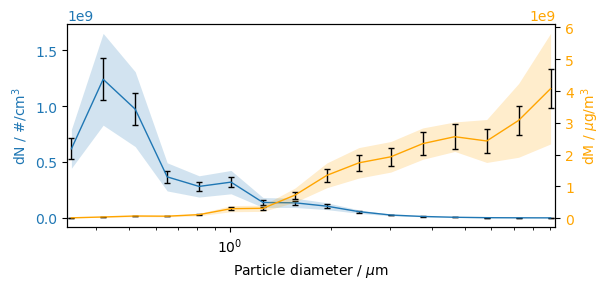

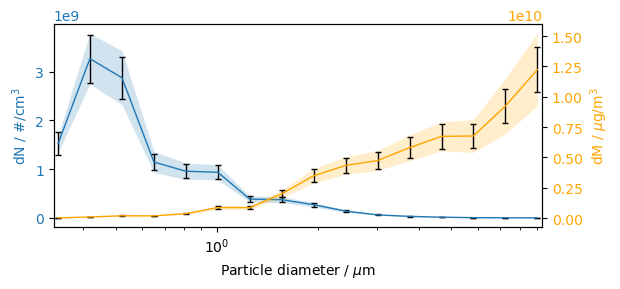

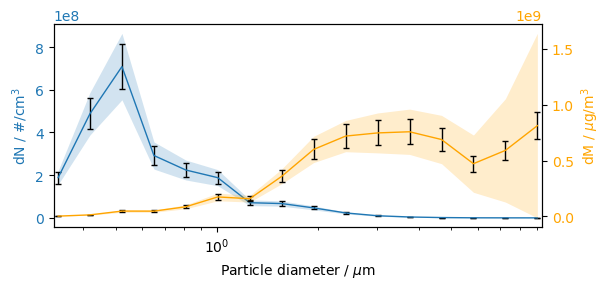

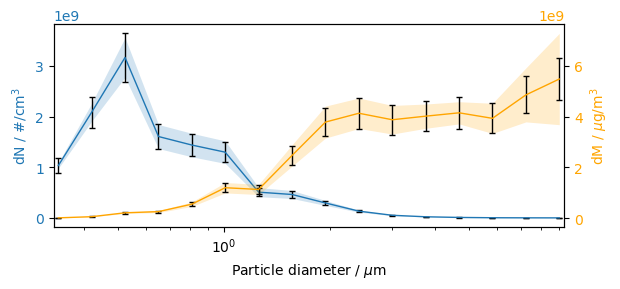

In [71]:
for i, key in enumerate(OPS_dict_keys):
    fig_name = 'Mean_concentrations/OPS_mean_' + key + '.png'

    fig, axes = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(axes, timestamps_exp[i], OPS_APS[key], OPS_mass_conc[key], OPS_bins, 'Time', OPS_mid_point, ['tab:blue', 'orange'], 0.15, OPS_ax_labels, True)

    axes.set_xlim(min(OPS_mid_point) - 0.01, max(OPS_mid_point) + 0.3)

    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)

In [6]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key))
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()
NanoScan_ax_labels = ['Particle diameter / nm', 'Mean concentration / #/cm$^{3}$']

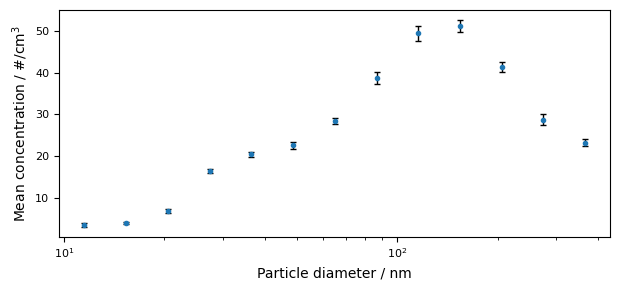

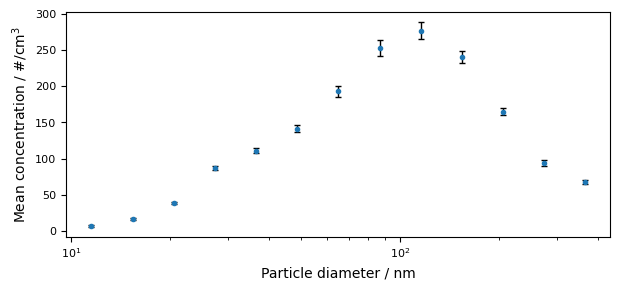

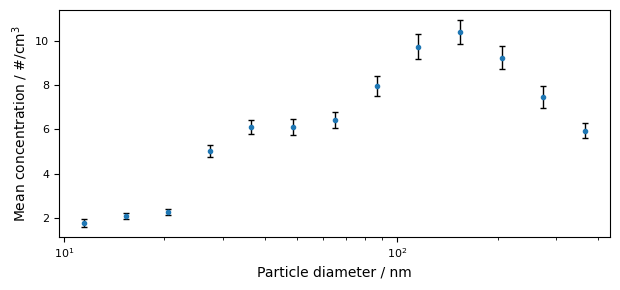

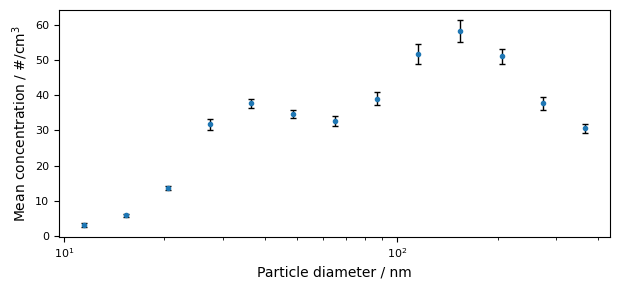

In [7]:
for i, key in enumerate(NanoScan_dict_keys):
    exp_number = i + 1
    fig_name = 'Mean_concentrations/NanoScan_mean_Exp' + str(exp_number) + '.png'

    fig, axes = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(axes, timestamps_exp[i], SMPS[key], NanoScan_Bins, 'Time', NanoScan_bin_mean, NanoScan_ax_labels)

    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)

In [8]:
APS_dict_keys = ['20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[4:56].to_list()
APS_bin_mean = [0.523]
for key in OPS_APS['20241016_APS'].keys()[5:56]:
    APS_bin_mean.append(float(key))

APS_ax_labels_number = ['Particle diameter / $\mu$m', 'Mean concentration / #/cm$^{3}$']
APS_ax_labels_mass = ['Particle diameter / $\mu$m', 'Mean concentration / mg/m$^{3}$']

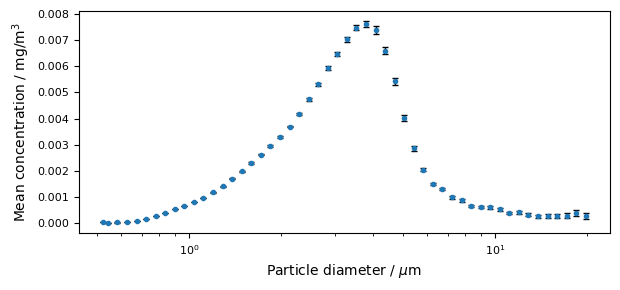

In [9]:
fig_name = 'Mean_concentrations/APS_mean_' + 'Exp1' + '.png'

fig, axes = plt.subplots(figsize = (6.3, 3))

plot_bin_mean(axes, timestamps_exp[0], OPS_APS['20241016_APS'], APS_bins, 'Time', APS_bin_mean, APS_ax_labels_mass)

fig.tight_layout()
fig.savefig(fig_name, dpi = 600)

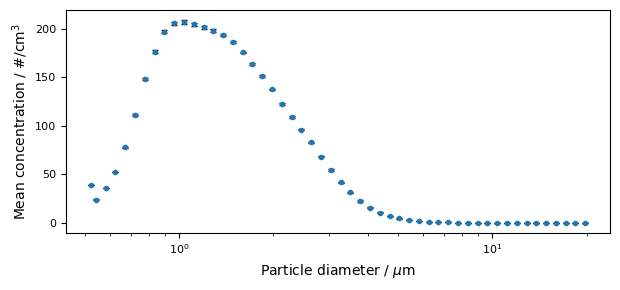

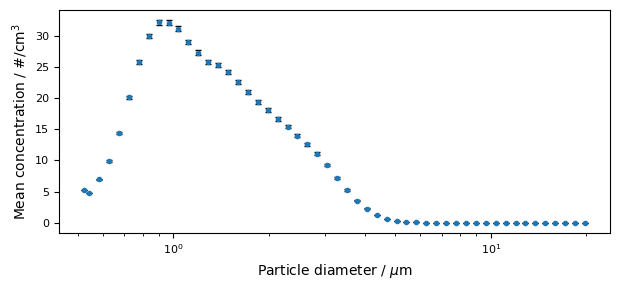

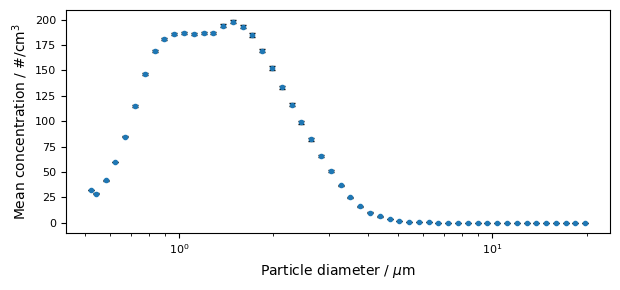

In [10]:
for i, key in enumerate(APS_dict_keys):
    exp_number = i + 2
    fig_name = 'Mean_concentrations/APS_mean_Exp' + str(exp_number) + '.png'

    fig, axes = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(axes, timestamps_exp[i+1], OPS_APS[key], APS_bins, 'Time', APS_bin_mean, APS_ax_labels_number)
    
    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)

In [11]:
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[83:196].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[83:196]:
    SMPS_bin_mean.append(float(key))

SMPS_ax_labels = ['Particle diameter / nm', 'Mean concentration/ #/cm$^{3}$']

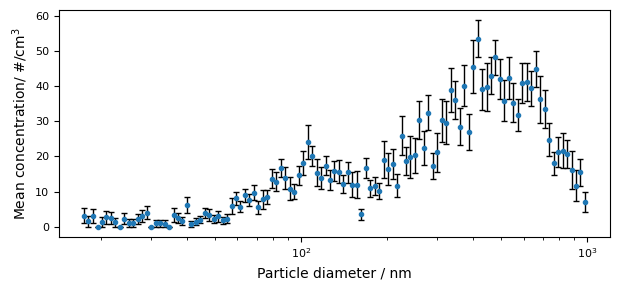

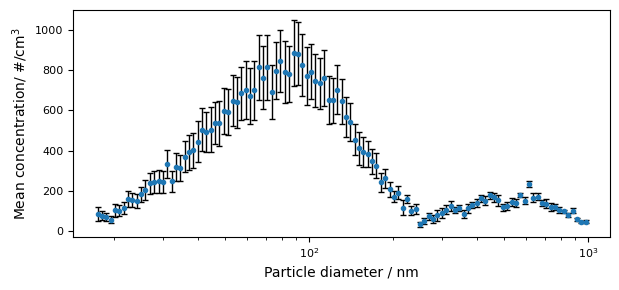

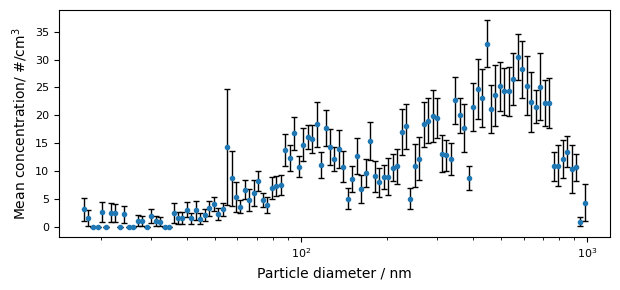

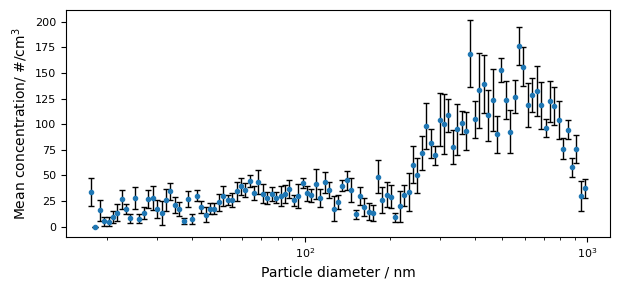

In [12]:
for i, key in enumerate(SMPS_dict_keys):
    exp_number = i + 1
    fig_name = 'Mean_concentrations/SMPS_mean_Exp' + str(exp_number) + '.png'

    fig, ax = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(ax, timestamps_exp[i], SMPS[key], SMPS_bins, 'Time', SMPS_bin_mean, SMPS_ax_labels)

    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)